# Working with filing data from the SEC's EDGAR service

In [65]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.webite-url.com")

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,414 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ge

## It is good to run in local system or calab pro since this would require storing the data not handled by free version of colab pro##

In [66]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [68]:
sns.set_style('whitegrid')

In [69]:
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets for the given range of quarters:

**Downloads over 40GB of data!**

In [70]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [71]:
from dateutil.relativedelta import relativedelta
today = pd.Timestamp(date.today() + relativedelta(years=0))
this_year = today.year
this_quarter = today.quarter
past_years = range(2014, this_year)

In [72]:
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])

In [84]:
filing_periods

[(2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3),
 (2020, 4),
 (2021, 1),
 (2021, 2)]

In [ ]:
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(f'{yr}-Q{qtr}', end=' ', flush=True)
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)
    url = SEC_URL + FSN_PATH + filing
    print (yr)
    # 2020q1 is currently (Oct 2020) in a different location; this may change at some point
    if yr == 2020 and qtr == 1:
        url = SEC_URL + 'files/node/add/data_distribution/' + filing
    response = requests.get(url).content
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        'https://www.sec.gov/files/node/add/data_distribution/2020q1_notes.zip'
        print('got bad zip file')
        continue


2014-Q1 2014
2014-Q2 2014
2014-Q3 2014
2014-Q4 2014
2015-Q1 2015
2015-Q2 2015
2015-Q3 2015
2015-Q4 2015
2016-Q1 2016
2016-Q2 2016
2016-Q3 2016
2016-Q4 2016
2017-Q1 2017
2017-Q2 2017
2017-Q3 2017
2017-Q4 2017
2018-Q1 2018
2018-Q2 2018
2018-Q3 2018
2018-Q4 2018
2019-Q1 2019
2019-Q2 2019
2019-Q3 2019
2019-Q4 2019
2020-Q1 2020
got bad zip file
2020-Q2 2020
2020-Q3 2020
2020-Q4 2020
2021-Q1 2021
got bad zip file
2021-Q2 2021
got bad zip file


## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

In [ ]:
for f in data_path.glob('**/*.tsv'):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name)

data/2016_1/source/txt.tsv
data/2019_3/source/tag.tsv
data/2014_3/source/txt.tsv
data/2017_1/source/tag.tsv
data/2016_3/source/tag.tsv
data/2014_2/source/txt.tsv
data/2017_2/source/tag.tsv
data/2019_2/source/tag.tsv
data/2014_4/source/txt.tsv
data/2015_3/source/txt.tsv
data/2015_4/source/txt.tsv
data/2014_1/source/txt.tsv
data/2020_2/source/tag.tsv
data/2020_3/source/tag.tsv
data/2015_1/source/txt.tsv
data/2017_4/source/tag.tsv
data/2015_2/source/txt.tsv


## Metadata json

In [ ]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries.

In [ ]:
sub = pd.read_parquet(data_path / '2017_3' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         6508 non-null   object 
 1   cik          6508 non-null   int64  
 2   name         6508 non-null   object 
 3   sic          6508 non-null   int64  
 4   countryba    6492 non-null   object 
 5   stprba       5984 non-null   object 
 6   cityba       6495 non-null   object 
 7   zipba        6488 non-null   object 
 8   bas1         6496 non-null   object 
 9   bas2         2838 non-null   object 
 10  baph         6496 non-null   object 
 11  countryma    6460 non-null   object 
 12  stprma       5980 non-null   object 
 13  cityma       6459 non-null   object 
 14  zipma        6459 non-null   object 
 15  mas1         6460 non-null   object 
 16  mas2         2793 non-null   object 
 17  countryinc   5976 non-null   object 
 18  stprinc      5769 non-null   object 
 19  ein   

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [ ]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-17-000009
cik                        320193
name                    APPLE INC
sic                          3571
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1            ONE INFINITE LOOP
form                         10-Q
period                   20170630
filed                    20170802
Name: 1197, dtype: object

In [ ]:
print (apple.cik)

320193


## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [90]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    #print (sub)
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

data/2016_1/parquet/sub.parquet
data/2019_3/parquet/sub.parquet
data/2014_3/parquet/sub.parquet
data/2017_1/parquet/sub.parquet
data/2016_3/parquet/sub.parquet
data/2019_4/parquet/sub.parquet
data/2014_2/parquet/sub.parquet
data/2017_2/parquet/sub.parquet
data/2019_2/parquet/sub.parquet
data/2014_4/parquet/sub.parquet
data/2015_3/parquet/sub.parquet
data/2018_1/parquet/sub.parquet
data/2019_1/parquet/sub.parquet
data/2015_4/parquet/sub.parquet
data/2020_4/parquet/sub.parquet
data/2018_4/parquet/sub.parquet
data/2018_3/parquet/sub.parquet
data/2014_1/parquet/sub.parquet
data/2020_2/parquet/sub.parquet
data/2020_3/parquet/sub.parquet
data/2015_1/parquet/sub.parquet
data/2016_4/parquet/sub.parquet
data/2017_4/parquet/sub.parquet
data/2017_3/parquet/sub.parquet
data/2018_2/parquet/sub.parquet
data/2015_2/parquet/sub.parquet
data/2016_2/parquet/sub.parquet


In [ ]:
aapl_subs

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,baph,countryma,stprma,cityma,zipma,mas1,mas2,countryinc,stprinc,ein,former,changed,afs,wksi,fye,form,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
481,0001193125-16-439878,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20151231.0,2016.0,Q1,20160127,2016-01-27 16:32:00.0,0,1,aapl-20151226.xml,1,None,NaN,NaN,None,NaN
1195,0000320193-19-000076,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20190630.0,2019.0,Q3,20190731,2019-07-31 16:32:00.0,0,1,a10-qq320196292019_htm.xml,1,None,NaN,NaN,NaN,NaN
582,0001193125-14-277160,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20140630.0,2014.0,Q3,20140723,2014-07-23 16:33:00.0,0,1,aapl-20140628.xml,1,None,NaN,NaN,None,NaN
590,0001628280-17-000717,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20161231.0,2017.0,Q1,20170201,2017-02-01 16:33:00.0,0,1,aapl-20161231.xml,1,None,NaN,NaN,None,NaN
661,0001628280-16-017809,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20160630.0,2016.0,Q3,20160727,2016-07-27 16:33:00.0,0,1,aapl-20160625.xml,1,None,NaN,NaN,None,NaN
3210,0000320193-19-000119,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,US,CA,942404110.0,APPLE INC,20070109.0,1-LAF,1,930.0,10-K,20190930.0,2019.0,FY,20191031,2019-10-30 18:13:00.0,0,1,a10-k20199282019_htm.xml,1,None,8.746980e+11,20190329.0,None,NaN
1281,0001193125-14-157311,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20140331.0,2014.0,Q2,20140424,2014-04-24 17:02:00.0,0,1,aapl-20140329.xml,1,None,NaN,NaN,None,NaN
2032,0001628280-17-004790,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20170331.0,2017.0,Q2,20170503,2017-05-03 16:32:00.0,0,1,aapl-20170401.xml,1,None,NaN,NaN,None,NaN
1909,0000320193-19-000066,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE APPLE PARK WAY,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,0,930.0,10-Q,20190331.0,2019.0,Q2,20190501,2019-05-01 16:32:00.0,0,1,a10-qq220193302019_htm.xml,1,None,NaN,NaN,None,NaN
775,0001193125-14-383437,320193,APPLE INC,3571.0,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,(408) 996-1010,US,CA,CUPERTINO,95014,ONE INFINITE LOOP,None,US,CA,942404110.0,APPLE COMPUTER INC,19970808.0,1-LAF,1,930.0,10-K,20140930.0,2014.0,FY,20141027,2014-10-27 17:12:00.0,0,1,aapl-20140927.xml,1,None,4.625220e+11,20140328.0,None,NaN


We find 15 quarterly 10-Q and 4 annual 10-K reports:

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [89]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):

    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

data/2016_1/parquet/num.parquet
data/2019_3/parquet/num.parquet
data/2014_3/parquet/num.parquet
data/2017_1/parquet/num.parquet
data/2016_3/parquet/num.parquet
data/2019_4/parquet/num.parquet
data/2014_2/parquet/num.parquet
data/2017_2/parquet/num.parquet
data/2019_2/parquet/num.parquet
data/2014_4/parquet/num.parquet
data/2015_3/parquet/num.parquet
data/2018_1/parquet/num.parquet
data/2019_1/parquet/num.parquet
data/2015_4/parquet/num.parquet
data/2020_4/parquet/num.parquet
data/2018_4/parquet/num.parquet
data/2018_3/parquet/num.parquet
data/2014_1/parquet/num.parquet
data/2020_2/parquet/num.parquet
data/2020_3/parquet/num.parquet
data/2015_1/parquet/num.parquet
data/2016_4/parquet/num.parquet
data/2017_4/parquet/num.parquet
data/2017_3/parquet/num.parquet
data/2018_2/parquet/num.parquet
data/2015_2/parquet/num.parquet
data/2016_2/parquet/num.parquet


In [74]:
aapl_nums

,adsh,tag,version,ddate,qtrs,uom,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
3662735,0001193125-16-439878,AccountsPayableCurrent,us-gaap/2015,2015-09-30,0,USD,0,3.549000e+10,None,0,0,None,0.000000,4.0,-6
3662736,0001193125-16-439878,AccountsPayableCurrent,us-gaap/2015,2015-12-31,0,USD,0,3.331200e+10,None,0,0,None,0.000000,5.0,-6
3668559,0001193125-16-439878,AccountsReceivableNetCurrent,us-gaap/2015,2015-09-30,0,USD,0,1.684900e+10,None,0,0,None,0.000000,4.0,-6
3668560,0001193125-16-439878,AccountsReceivableNetCurrent,us-gaap/2015,2015-12-31,0,USD,0,1.295300e+10,None,0,0,None,0.000000,5.0,-6
3671258,0001193125-16-439878,AccruedLiabilitiesCurrent,us-gaap/2015,2015-09-30,0,USD,0,2.518100e+10,None,0,0,None,0.000000,4.0,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328079,0001193125-16-559625,StockRepurchasedAndRetiredDuringPeriodWeighted...,0001193125-16-559625,2016-03-31,1,USD,0,9.754000e+01,None,0,1,None,0.013699,5.0,2
3328080,0001193125-16-559625,UpfrontPaymentUnderAcceleratedShareRepurchaseP...,0001193125-16-559625,2015-02-28,2,USD,0,9.000000e+09,None,0,1,None,-0.312328,0.0,32767
3328081,0001193125-16-559625,UpfrontPaymentUnderAcceleratedShareRepurchaseP...,0001193125-16-559625,2015-07-31,1,USD,0,6.000000e+09,None,0,1,None,0.002740,0.0,32767
3328082,0001193125-16-559625,UpfrontPaymentUnderAcceleratedShareRepurchaseP...,0001193125-16-559625,2014-12-31,4,USD,0,1.200000e+10,None,0,1,None,0.010959,0.0,32767


In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL.

In [ ]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26721 entries, 3662735 to 3328083
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      26721 non-null  object        
 1   tag       26721 non-null  object        
 2   version   26721 non-null  object        
 3   ddate     26721 non-null  datetime64[ns]
 4   qtrs      26721 non-null  int64         
 5   uom       26721 non-null  object        
 6   iprx      26721 non-null  int64         
 7   value     26657 non-null  float64       
 8   footnote  68 non-null     object        
 9   footlen   26721 non-null  int64         
 10  dimn      26721 non-null  int64         
 11  coreg     0 non-null      object        
 12  durp      26721 non-null  float64       
 13  datp      26721 non-null  float64       
 14  dcml      26721 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 3.3+ MB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [ ]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [83]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earninhgs prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)

eps_dummy = eps[['ddate', 'value']].set_index("ddate")

eps = eps[['ddate', 'value']].set_index('ddate').sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

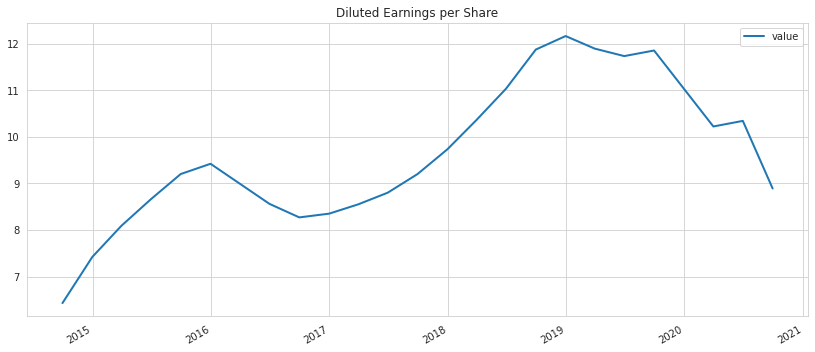

In [ ]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [ ]:

!pip install  pandas-datareader>=0.7

In [ ]:
symbol = 'AAPL'
import time
import datetime
#import os
#api_key=os.getenv('quandl')

aapl_stock = (web.
          DataReader(symbol,api_key=os.getenv('quandl'),data_source="yahoo", start=eps.index.min(),end = date.today())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])

aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2014-09-30 to 2020-09-30
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1512 non-null   float64
 1   Low        1512 non-null   float64
 2   Open       1512 non-null   float64
 3   Close      1512 non-null   float64
 4   Volume     1512 non-null   float64
 5   Adj Close  1512 non-null   float64
dtypes: float64(6)
memory usage: 119.9 KB


In [ ]:
aapl_stock.rename({"Adj Close":"AdjClose"}, axis='columns',inplace=True)

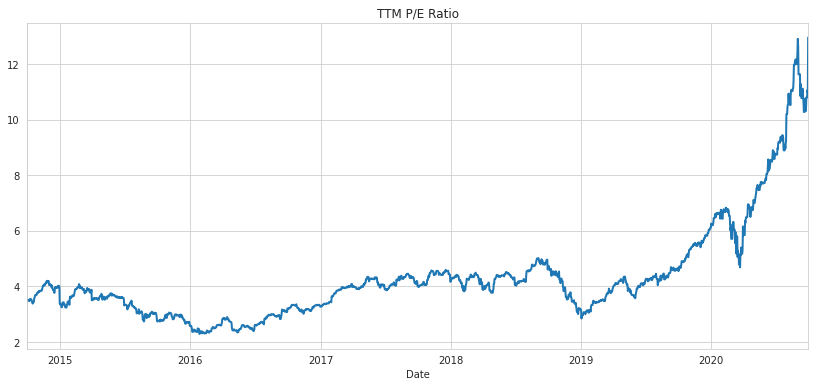

In [75]:
pe = (aapl_stock["AdjClose"]).to_frame('price').join(eps)
pe.rename({"value":"eps"}, axis='columns',inplace=True)
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [76]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2014-09-30 to 2020-09-30
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2193 non-null   float64
 1   eps        2193 non-null   float64
 2   P/E Ratio  2193 non-null   float64
dtypes: float64(3)
memory usage: 68.5 KB


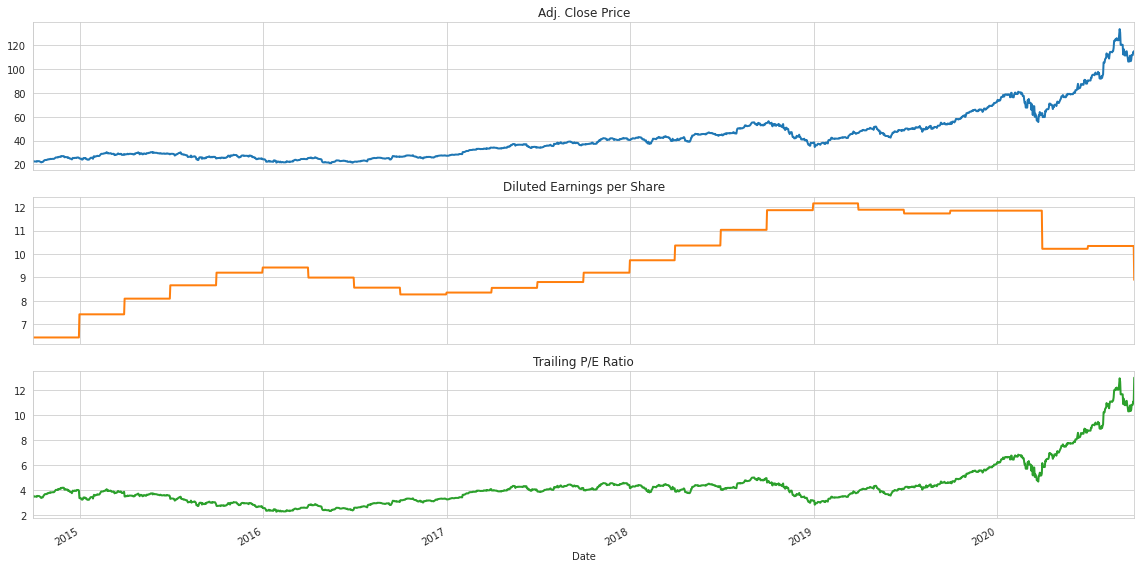

In [77]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [78]:
aapl_nums.tag.value_counts()

CashAndCashEquivalentsAtCarryingValue                                                                               810
DebtInstrumentInterestRateEffectivePercentage                                                                       788
OperatingIncomeLoss                                                                                                 658
AvailableForSaleSecuritiesNoncurrent                                                                                560
AvailableForSaleSecuritiesAmortizedCost                                                                             560
                                                                                                                   ... 
ShareBasedCompensationArrangementsByShareBasedPaymentAwardOptionsGrantsInPeriodWeightedAverageExercisePrice           1
ResultOfLegalProceedingsAwardUpHeld                                                                                   1
TaxCutsAndJobsActOf2017IncompleteAccount

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [79]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

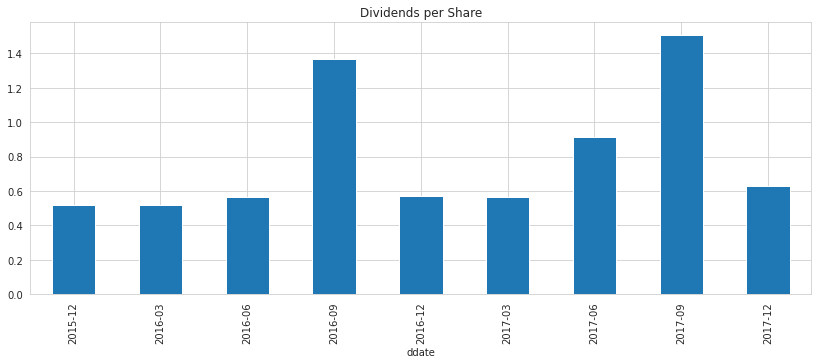

In [80]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [81]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statesments here:

In [82]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000799288-16-000122,AmendmentFlag,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,5,5,None,0,FD2015Q4YTD,false
1,0000799288-16-000122,CurrentFiscalYearEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,7,7,None,0,FD2015Q4YTD,--01-29
2,0000799288-16-000122,DocumentFiscalPeriodFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,2,2,None,0,FD2015Q4YTD,FY
3,0000799288-16-000122,DocumentFiscalYearFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,4,4,None,0,FD2015Q4YTD,2015
4,0000799288-16-000122,DocumentPeriodEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,10,10,None,0,FD2015Q4YTD,2016-01-29
